# A6.2 Tic Tac Toe

- 6.2: *Changed `ntrials = 4000` to `ntrials = 8000` in run() and provided new example results.*
- 6.1: *Added one line to make_samples to avoid errors encountered by some of you in numpy.*

For this assignment you will run a number of comparisons between different neural networks trained through Q-learning to predict Q functions for Player X and for Player O in a simple Tic Tac Toe game.  

All but one simple function is provided, so your effort will be in choosing the parameters for the experiments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import neuralnetwork_regression as nn

In [2]:
def initial_state():
    return np.array([0] * 9)

def next_state(s, a, marker):  # s is a board, and a is an index into the cells of the board, marker is 1 or -1
    s = s.copy()
    s[a] = 1 if marker == 'X' else -1
    return s

def reinforcement(s):
    if won('X', s):
        return 1
    if won('O', s):
        return -1
    return 0

def won(player, s):
    marker = 1 if player == 'X' else -1
    combos = np.array((0,1,2, 3,4,5, 6,7,8, 0,3,6, 1,4,7, 2,5,8, 0,4,8, 2,4,6))
    return np.any(np.all(marker == s[combos].reshape((-1, 3)), axis=1))

def draw(s):
    return sum(s == 0) == 0

def valid_actions(state):
    return np.where(state == 0)[0]

In [3]:
def stack_sa(s, a):
    return np.hstack((s, a)).reshape(1, -1)

def other_player(player):
    return 'X' if player == 'O' else 'O'

In [4]:
def epsilon_greedy(Qnet, state, epsilon):
    
    actions = valid_actions(state)
    
    if np.random.uniform() < epsilon:
        # Random Move
        action = np.random.choice(actions)
        
    else:
        # Greedy Move
        np.random.shuffle(actions)
        Qs = np.array([Qnet.use(stack_sa(state, a)) for a in actions])
        action = actions[np.argmax(Qs)]
        
    return action

In [5]:
def make_samples(Qnets, initial_state_f, next_state_f, reinforcement_f, epsilon):
    '''Run one game'''
    Samples = {'X': {'SA': [], 'R': [], 'Qn': []},
               'O': {'SA': [], 'R': [], 'Qn': []}}

    s = initial_state_f()
    player = 'X'

    while True:
        
        a = epsilon_greedy(Qnets[player], s, epsilon)
        sn = next_state_f(s, a, player)
        r = reinforcement_f(sn)

        Samples[player]['SA'].append(stack_sa(s, a))
        Samples[player]['R'].append(r)   # r is with respect to X
        Samples[player]['Qn'].append(0.0)  # fill in layer

        if r != 0 or draw(sn):
            Samples[other_player(player)]['R'][-1] = r  
            break

        s = sn
        player = other_player(player)  # switch

    for player in ['X', 'O']:
        Samps = Samples[player]
        Samps['SA'] = np.vstack(Samps['SA'])
        Samps['R'] = np.array(Samps['R']).reshape(-1, 1)
        Samps['Qn'] =  np.array(Samps['Qn']).reshape(-1 ,1)  # this statement added in A6.1

    # Assign all Qn's, based on following state, but go every other state to do all X values,
    ends_with_O = len(Samples['X']) > len(Samples['O'])
    if ends_with_O:
        # O wins
        Samples['X']['Qn'][:-1] = Qnets['X'].use(Samples['X']['SA'][1:, :])
        Samples['O']['Qn'][:-1] = Qnets['O'].use(Samples['O']['SA'][1:])
    else:
        # X wins or draw
        Samples['X']['Qn'][:-1] = Qnets['X'].use(Samples['X']['SA'][1:])
        Samples['O']['Qn'][:-1] = Qnets['O'].use(Samples['O']['SA'][1:])

    for player in ['X', 'O']:
        Samps = Samples[player]
        Samps['Qn'] = np.array(Samps['Qn']).reshape(-1, 1)

    return Samples

In [6]:
def plot_status(outcomes, epsilons, n_trials, trial):
    if trial == 0:
        return
    outcomes = np.array(outcomes)
    n_per = 10
    n_bins = (trial + 1) // n_per
    if n_bins == 0:
        return
    outcome_rows = outcomes[:n_per * n_bins].reshape((-1, n_per))
    outcome_rows = outcome_rows[:trial // n_per + 1, :]
    avgs = np.mean(outcome_rows, axis=1)
    
    plt.subplot(3, 1, 1)
    xs = np.linspace(n_per, n_per * n_bins, len(avgs))
    plt.plot(xs, avgs)
    plt.ylim(-1.1, 1.1)
    plt.xlabel('Games')
    plt.ylabel('Mean of Outcomes') # \n(0=draw, 1=X win, -1=O win)')
    plt.title(f'Bins of {n_per:d} Games')
    
    plt.subplot(3, 1, 2)
    plt.plot(xs, np.sum(outcome_rows == -1, axis=1), 'r-', label='Losses')
    plt.plot(xs, np.sum(outcome_rows == 0, axis=1), 'b-', label='Draws')
    plt.plot(xs, np.sum(outcome_rows == 1, axis=1), 'g-', label='Wins')
    plt.legend(loc='center')
    plt.ylabel(f'Number of Games\nin Bins of {n_per:d}')
    
    plt.subplot(3, 1, 3)
    plt.plot(epsilons[:trial])
    plt.ylabel('$\epsilon$')

In [7]:
def setup_standardization(Qnet, Xmeans, Xstds, Tmeans, Tstds):
    Qnet.Xmeans = np.array(Xmeans)
    Qnet.Xstds = np.array(Xstds)
    Qnet.Tmeans = np.array(Tmeans)
    Qnet.Tstds = np.array(Tstds)

In [18]:
from IPython.display import display, clear_output

def run(X_hidden_units_list_of_lists, O_hidden_units_list_of_lists, n_epochs_list, learning_rate_list, 
        repetitions=5, graphics=False):
    
    if graphics:
        fig = plt.figure(figsize=(10, 10))
        
    n_trials = 8000         # number of repetitions of makeSamples-updateQ loop
    
    gamma = 1.0        # discount factor
    final_epsilon = 0.01 # value of epsilon at end of simulation. Decay rate is calculated
    epsilon_decay = np.exp(np.log(final_epsilon) / (n_trials)) # to produce this final value

    results = []
    for n_epochs in n_epochs_list:
        for learning_rate in learning_rate_list:
            for X_nh in X_hidden_units_list_of_lists:
                for O_nh in O_hidden_units_list_of_lists:
                
                    last_fifth_outcomes = []

                    # RRn multiple experiments for these parameter values and average the results
                    for rep in range(repetitions):
                        
                        
                        print(rep + 1, end=' ')
                        # Qnet for Player 'X'
                        QnetX = nn.NeuralNetwork(9 + 1, X_nh, 1)
                        # Qnet for Player 'O'
                        QnetO = nn.NeuralNetwork(9 + 1, O_nh, 1)
                        Qnets = {'X': QnetX, 'O': QnetO}

                        # Inputs are 9 TTT cells plus 1 action
                        setup_standardization(QnetX, [0] * 10, [1] * 10, [0], [1])
                        setup_standardization(QnetO, [0] * 10, [1] * 10, [0], [1])

                        epsilon = 1         # initial epsilon value
                        outcomes = []
                        epsilon_trace = []

                        # Train for n_trials
                        for trial in range(n_trials):

                            Samples = make_samples(Qnets, initial_state, next_state, reinforcement, epsilon)

                            Samps = Samples['X']
                            SA = Samps['SA']
                            R = Samps['R']
                            Qn = Samps['Qn']
                            T = R + gamma * Qn
                            Qnets['X'].train(SA, T, n_epochs, learning_rate, method='sgd', verbose=False)

                            Samps = Samples['O']
                            SA = Samps['SA']
                            R = - Samps['R']  # r is with respect to X, so negate it
                            Qn = Samps['Qn']
                            T = R + gamma * Qn
                            Qnets['O'].train(SA, T, n_epochs, learning_rate, method='sgd', verbose=False)

                            outcomes.append(Samples['X']['R'][-1])
                            epsilon_trace.append(epsilon)

                            epsilon *= epsilon_decay
                            
                            if graphics and (trial + 1 == n_trials or trial % (n_trials / 20) == 0):
                                plt.clf()
                                plot_status(outcomes, epsilon_trace, n_trials, trial)
                                clear_output(wait=True)
                                display(fig)

                        # For each repetition collect the mean of the outcome for the final fifth games
                        last_fifth_outcomes.append(np.mean(outcomes[-n_trials // 5:]))
                        print(f'{last_fifth_outcomes[-1]:.1f},', end=' ')
                        
                    results.append([X_nh, O_nh, n_epochs, learning_rate, np.mean(last_fifth_outcomes)])
                    print(results[-1])
                    
    if graphics:
        clear_output(wait=True)
        
    return pandas.DataFrame(results, columns=('X_nh', 'O_nh', 'n_epochs', 'lr', 'last_fifth_outcomes')), Qnets

Here is an example run with just one value for each of the four parameters.  Only 1 repetition will be performed.

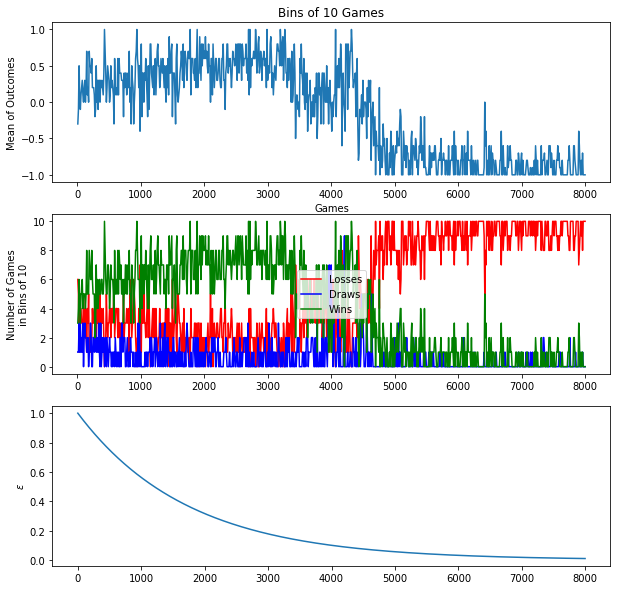

In [9]:
result, Qnets = run([[]], [[100, 20]], [40], [0.001], 1, True)

In [10]:
Qnets

{'X': NeuralNetwork(10, [], 1, 'tanh'),
 'O': NeuralNetwork(10, [100, 20], 1, 'tanh')}

In [11]:
print(Qnets['X'])
print(Qnets['O'])

NeuralNetwork(10, [], 1, 'tanh') trained for 40 epochs, final training error 0.0675
NeuralNetwork(10, [100, 20], 1, 'tanh') trained for 40 epochs, final training error 0.0023


Change the following function to compare different neural network structures for X and for O and also try multiple values for `n_epochs` and `learning_rate`.  Include the results of running your function in this notebook.

Try at least three different network structures for each player and three different values for `n_epochs` and three different values for `learning_rate`.  Use at least 5 for the second to last argument so your results are averaged over 5 repetitions. Try to find parameters for which O consistently wins, and ones for which X consistently wins. Include these choices in the lists of parameter values in the following function.

Discuss your results.  Do they make sense?

Here is an example run, though you must use at least three values for each of the first four arguments.

# Making X winning the Game

In [20]:
def myresult():
    result, Qnets = run(X_hidden_units_list_of_lists=[[5,5], [10, 10],[20,20]],
                        O_hidden_units_list_of_lists=[[],[2,2],[5,5] ],
                        n_epochs_list=[10,20,30],
                        learning_rate_list=[0.001,0.002,0.05], 
                        repetitions=5, graphics=False)
    return result

import time
start_time = time.time()

result = myresult()

print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')

result

1 0.9, 2 0.9, 3 0.3, 4 0.9, 5 1.0, [[5, 5], [], 10, 0.001, 0.8077500000000001]
1 0.9, 2 0.8, 3 0.9, 4 0.9, 5 0.9, [[5, 5], [2, 2], 10, 0.001, 0.876375]
1 0.2, 2 0.9, 3 1.0, 4 0.9, 5 0.9, [[5, 5], [5, 5], 10, 0.001, 0.7875]
1 1.0, 2 0.9, 3 0.9, 4 0.9, 5 0.9, [[10, 10], [], 10, 0.001, 0.94475]
1 0.7, 2 0.9, 3 0.4, 4 0.9, 5 0.9, [[10, 10], [2, 2], 10, 0.001, 0.756]
1 0.0, 2 0.9, 3 0.9, 4 0.9, 5 0.9, [[10, 10], [5, 5], 10, 0.001, 0.76]
1 0.9, 2 0.9, 3 1.0, 4 0.9, 5 1.0, [[20, 20], [], 10, 0.001, 0.9401250000000001]
1 0.9, 2 0.9, 3 0.9, 4 0.9, 5 0.9, [[20, 20], [2, 2], 10, 0.001, 0.9065]
1 0.9, 2 0.9, 3 0.8, 4 0.2, 5 0.9, [[20, 20], [5, 5], 10, 0.001, 0.759125]
1 1.0, 2 1.0, 3 1.0, 4 0.9, 5 0.9, [[5, 5], [], 10, 0.002, 0.9493749999999999]
1 0.4, 2 0.8, 3 0.9, 4 0.9, 5 1.0, [[5, 5], [2, 2], 10, 0.002, 0.7895000000000001]
1 0.9, 2 0.2, 3 0.4, 4 0.8, 5 0.9, [[5, 5], [5, 5], 10, 0.002, 0.6463749999999999]
1 1.0, 2 1.0, 3 1.0, 4 1.0, 5 1.0, [[10, 10], [], 10, 0.002, 0.9665000000000001]
1 0.9, 2 

C:\Softwares\anaconda\lib\site-packages\numpy\core\_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\shriram gaddam\neuralnetwork_regression.py:182: RuntimeWarning: overflow encountered in multiply
  delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
C:\Users\shriram gaddam\neuralnetwork_regression.py:161: RuntimeWarning: overflow encountered in square
  mean_sq_error = np.mean((T - Ys[-1]) ** 2)
C:\Users\shriram gaddam\neuralnetwork_regression.py:182: RuntimeWarning: overflow encountered in matmul
  delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
C:\Users\shriram gaddam\neuralnetwork_regression.py:182: RuntimeWarning: invalid value encountered in multiply
  delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
C:\Users\shriram gaddam\neuralnetwork_regression.py:175: RuntimeWarning: overflow encountered in matmul
  self.dE_dWs[layeri][1:, :] = self.Ys[layeri].

0.6, 2 0.7, 3 0.6, 4 0.6, 5 0.6, [[5, 5], [], 10, 0.05, 0.626875]
1 0.9, 2 1.0, 3 0.9, 4 1.0, 5 0.8, [[5, 5], [2, 2], 10, 0.05, 0.9195]
1 0.9, 2 0.9, 3 0.9, 4 0.6, 5 1.0, [[5, 5], [5, 5], 10, 0.05, 0.850625]
1 0.6, 2 0.6, 3 0.6, 4 0.7, 5 0.6, [[10, 10], [], 10, 0.05, 0.599625]
1 1.0, 2 1.0, 3 0.9, 4 1.0, 5 0.9, [[10, 10], [2, 2], 10, 0.05, 0.9649999999999999]
1 1.0, 2 0.8, 3 0.9, 4 1.0, 5 1.0, [[10, 10], [5, 5], 10, 0.05, 0.9253750000000001]
1 0.6, 2 

C:\Users\shriram gaddam\neuralnetwork_regression.py:155: RuntimeWarning: invalid value encountered in matmul
  self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])


0.6, 3 0.6, 4 0.6, 5 0.6, [[20, 20], [], 10, 0.05, 0.6275000000000001]
1 0.9, 2 1.0, 3 0.9, 4 0.8, 5 1.0, [[20, 20], [2, 2], 10, 0.05, 0.9185000000000001]
1 1.0, 2 0.9, 3 1.0, 4 1.0, 5 0.7, [[20, 20], [5, 5], 10, 0.05, 0.898]
1 0.9, 2 1.0, 3 0.9, 4 0.9, 5 0.9, [[5, 5], [], 20, 0.001, 0.942]
1 0.8, 2 0.9, 3 0.9, 4 0.5, 5 1.0, [[5, 5], [2, 2], 20, 0.001, 0.8296250000000001]
1 0.9, 2 0.4, 3 0.8, 4 -0.5, 5 0.9, [[5, 5], [5, 5], 20, 0.001, 0.5041249999999999]
1 1.0, 2 0.9, 3 1.0, 4 0.9, 5 1.0, [[10, 10], [], 20, 0.001, 0.95175]
1 0.5, 2 0.9, 3 1.0, 4 1.0, 5 0.9, [[10, 10], [2, 2], 20, 0.001, 0.85375]
1 0.9, 2 0.9, 3 0.9, 4 0.7, 5 1.0, [[10, 10], [5, 5], 20, 0.001, 0.8865000000000001]
1 0.9, 2 0.9, 3 1.0, 4 0.9, 5 1.0, [[20, 20], [], 20, 0.001, 0.95]
1 0.9, 2 0.9, 3 1.0, 4 1.0, 5 0.9, [[20, 20], [2, 2], 20, 0.001, 0.92825]
1 0.9, 2 0.7, 3 1.0, 4 0.8, 5 0.9, [[20, 20], [5, 5], 20, 0.001, 0.8396250000000001]
1 1.0, 2 0.9, 3 1.0, 4 0.9, 5 1.0, [[5, 5], [], 20, 0.002, 0.958375]
1 1.0, 2 1.0, 3 1

C:\Users\shriram gaddam\neuralnetwork_regression.py:161: RuntimeWarning: invalid value encountered in subtract
  mean_sq_error = np.mean((T - Ys[-1]) ** 2)
C:\Users\shriram gaddam\neuralnetwork_regression.py:167: RuntimeWarning: invalid value encountered in subtract
  error = T - self.Ys[-1]


0.7, 2 0.5, 3 0.5, 4 0.5, 5 0.6, [[5, 5], [], 20, 0.05, 0.5645000000000001]
1 0.9, 2 0.9, 3 0.9, 4 0.8, 5 0.8, [[5, 5], [2, 2], 20, 0.05, 0.8674999999999999]
1 0.8, 2 0.9, 3 0.9, 4 0.7, 5 0.9, [[5, 5], [5, 5], 20, 0.05, 0.869125]
1 0.6, 2 0.5, 3 0.5, 4 0.6, 5 0.6, [[10, 10], [], 20, 0.05, 0.5375]
1 0.5, 2 1.0, 3 0.8, 4 0.9, 5 0.7, [[10, 10], [2, 2], 20, 0.05, 0.7733749999999999]
1 0.7, 2 0.5, 3 0.8, 4 0.9, 5 0.6, [[10, 10], [5, 5], 20, 0.05, 0.701125]
1 0.4, 2 0.4, 3 0.5, 4 0.5, 5 0.4, [[20, 20], [], 20, 0.05, 0.44975]
1 1.0, 2 0.4, 3 0.9, 4 0.7, 5 0.9, [[20, 20], [2, 2], 20, 0.05, 0.7785000000000001]
1 0.9, 2 0.9, 3 0.8, 4 0.5, 5 0.8, [[20, 20], [5, 5], 20, 0.05, 0.7755]
1 1.0, 2 1.0, 3 1.0, 4 0.9, 5 0.9, [[5, 5], [], 30, 0.001, 0.952]
1 0.3, 2 1.0, 3 0.9, 4 0.9, 5 0.8, [[5, 5], [2, 2], 30, 0.001, 0.7635]
1 1.0, 2 1.0, 3 0.7, 4 1.0, 5 0.9, [[5, 5], [5, 5], 30, 0.001, 0.9102499999999999]
1 1.0, 2 1.0, 3 1.0, 4 0.9, 5 1.0, [[10, 10], [], 30, 0.001, 0.960875]
1 0.9, 2 0.7, 3 0.9, 4 1.0, 

,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,"[5, 5]",[],10,0.001,0.807750
1,"[5, 5]","[2, 2]",10,0.001,0.876375
2,"[5, 5]","[5, 5]",10,0.001,0.787500
3,"[10, 10]",[],10,0.001,0.944750
4,"[10, 10]","[2, 2]",10,0.001,0.756000
...,...,...,...,...,...
76,"[10, 10]","[2, 2]",30,0.050,0.694000
77,"[10, 10]","[5, 5]",30,0.050,0.744125
78,"[20, 20]",[],30,0.050,0.467375
79,"[20, 20]","[2, 2]",30,0.050,0.811625


In [21]:
pandas.set_option('display.max_rows', None)

In [22]:
result

,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,"[5, 5]",[],10,0.001,0.807750
1,"[5, 5]","[2, 2]",10,0.001,0.876375
2,"[5, 5]","[5, 5]",10,0.001,0.787500
3,"[10, 10]",[],10,0.001,0.944750
4,"[10, 10]","[2, 2]",10,0.001,0.756000
5,"[10, 10]","[5, 5]",10,0.001,0.760000
6,"[20, 20]",[],10,0.001,0.940125
7,"[20, 20]","[2, 2]",10,0.001,0.906500
8,"[20, 20]","[5, 5]",10,0.001,0.759125
9,"[5, 5]",[],10,0.002,0.949375


# Observations for X:

I have ran the experiment with 3 different sets of learning rate, epochs, neural networks X and O hidden layers each .Total time took for the experiment is 597 minutes(10 hrs).Initially i have started with two hidden layers with 5 each hidden units for  X and no hidden units for O.we have a good winning rate for X maximum value is 0.95 for the learning rate 0.002 and number of epochs 20. Even for epochs 10 also with the same learning rate and epochs 10 its value is upto 0.94.For remaing number of learning rates and epochs winning strategy is good but not the best.learning rate plays prime role for this neural network structure.Also high learning rate is not a good option even though its value >0.5 it is not best. Now we increase the number of hiddens in X and with 0 hiddens in 0. the increase in hiddens always increase the win percentage with maximum reached upto 0.98
with optimal learning rate parameter 0.002 and increase in epochs is proportional to the winning percentage of X.So we can say that more complex the neural network and better training of the network X and simple linear network of O it is always favours for X.Now when we include the hidden layers network structure for O results are somewhat different than expected.First thing is 
even though win favours for X  when both are complex structres the network with more number of hiddens eg:[20,20] favours more than [10,10].Increase in number of epochs doesn't play better role for improvising winning rather the least value out of all results results with maximum number of epochs 30(near to 0.2 and likely to be game drawn).increase in learning is not a better option.the best performance comes with optimal learning rate of 0.002 not by the value less than that(0.001).It indicates that
learning rate should be optimum ,if it is very less learning for the X is slow and  is not best at playing deterministic postions. Out of all the results best performance comes from network with both high numbers of hiddens in X[10,10] and low number of hiddens in O [2,2] with better learning rate (0.02) and with epochs of 20 and 30 .which is around 98% winning rate(maximum).so increase in epochs plays a good role with above kind of neural network structure.there is no result where winning of O dominated . Consistent of winning of X can be achieved with last mentioned structure  maximum winning rate .

# strategy for winning O

In [23]:
def myresult():
    result, Qnets = run(X_hidden_units_list_of_lists=[[], [2,2]],
                        O_hidden_units_list_of_lists=[[20,20,20], [100, 100] ],
                        n_epochs_list=[20],
                        learning_rate_list=[0.005], 
                        repetitions=5, graphics=False)
    return result

import time
start_time = time.time()

result5 = myresult()

print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')

result5

1 -0.9, 2 -0.4, 3 -0.5, 4 -0.5, 5 -0.9, [[], [20, 20, 20], 20, 0.005, -0.632]
1 -0.9, 2 -0.7, 3 0.3, 4 0.2, 5 -0.3, [[], [100, 100], 20, 0.005, -0.27837499999999993]
1 0.7, 2 -0.1, 3 0.6, 4 0.6, 5 1.0, [[2, 2], [20, 20, 20], 20, 0.005, 0.5507500000000001]
1 -0.4, 2 0.3, 3 -0.4, 4 -0.3, 5 0.3, [[2, 2], [100, 100], 20, 0.005, -0.12974999999999998]
Took 27.0 minutes.


,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[],"[20, 20, 20]",20,0.005,-0.632000
1,[],"[100, 100]",20,0.005,-0.278375
2,"[2, 2]","[20, 20, 20]",20,0.005,0.550750
3,"[2, 2]","[100, 100]",20,0.005,-0.129750


In [24]:
def myresult():
    result, Qnets = run(X_hidden_units_list_of_lists=[[], [1]],
                        O_hidden_units_list_of_lists=[[100,100],[200,200,200] ],
                        n_epochs_list=[20],
                        learning_rate_list=[0.005], 
                        repetitions=5, graphics=False)
    return result

import time
start_time = time.time()

result6 = myresult()

print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')

result6

1 -0.6, 2 -0.9, 3 -0.7, 4 -0.7, 5 0.9, [[], [100, 100], 20, 0.005, -0.39]
1 -0.9, 2 -0.8, 3 -0.9, 4 -0.6, 5 -0.8, [[], [200, 200, 200], 20, 0.005, -0.8108749999999999]
1 -0.2, 2 -0.9, 3 -0.4, 4 -0.2, 5 0.1, [[1], [100, 100], 20, 0.005, -0.308]
1 -0.6, 2 -0.1, 3 -0.3, 4 0.3, 5 0.0, [[1], [200, 200, 200], 20, 0.005, -0.137625]
Took 31.5 minutes.


,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[],"[100, 100]",20,0.005,-0.390000
1,[],"[200, 200, 200]",20,0.005,-0.810875
2,[1],"[100, 100]",20,0.005,-0.308000
3,[1],"[200, 200, 200]",20,0.005,-0.137625


In [25]:
def myresult():
    result, Qnets = run(X_hidden_units_list_of_lists=[[], [1]],
                        O_hidden_units_list_of_lists=[[50,50,50],[100,100] ],
                        n_epochs_list=[10],
                        learning_rate_list=[0.001], 
                        repetitions=5, graphics=False)
    return result

import time
start_time = time.time()

result7 = myresult()

print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')

result7

1 -0.2, 2 0.1, 3 -0.1, 4 -0.4, 5 -0.6, [[], [50, 50, 50], 10, 0.001, -0.240375]
1 -0.7, 2 -0.8, 3 -0.5, 4 -0.9, 5 -0.9, [[], [100, 100], 10, 0.001, -0.7305]
1 0.0, 2 -0.1, 3 -0.5, 4 0.0, 5 0.1, [[1], [50, 50, 50], 10, 0.001, -0.078375]
1 -0.7, 2 -0.2, 3 -0.7, 4 -0.8, 5 -0.7, [[1], [100, 100], 10, 0.001, -0.623375]
Took 12.7 minutes.


,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[],"[50, 50, 50]",10,0.001,-0.240375
1,[],"[100, 100]",10,0.001,-0.730500
2,[1],"[50, 50, 50]",10,0.001,-0.078375
3,[1],"[100, 100]",10,0.001,-0.623375


In [26]:
def myresult():
    result, Qnets = run(X_hidden_units_list_of_lists=[[], [1]],
                        O_hidden_units_list_of_lists=[[100,100],[200,200,200] ],
                        n_epochs_list=[15],
                        learning_rate_list=[0.005], 
                        repetitions=5, graphics=False)
    return result

import time
start_time = time.time()

result8 = myresult()

print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')

result8

1 -0.9, 2 0.5, 3 -0.9, 4 -0.8, 5 -0.9, [[], [100, 100], 15, 0.005, -0.5900000000000001]
1 -0.3, 2 -0.9, 3 -0.2, 4 -0.9, 5 -0.9, [[], [200, 200, 200], 15, 0.005, -0.6355]
1 -0.9, 2 0.1, 3 0.4, 4 0.6, 5 0.2, [[1], [100, 100], 15, 0.005, 0.084]
1 -0.5, 2 0.1, 3 -0.3, 4 0.5, 5 -0.9, [[1], [200, 200, 200], 15, 0.005, -0.233875]
Took 27.0 minutes.


,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[],"[100, 100]",15,0.005,-0.590000
1,[],"[200, 200, 200]",15,0.005,-0.635500
2,[1],"[100, 100]",15,0.005,0.084000
3,[1],"[200, 200, 200]",15,0.005,-0.233875


In [27]:
import pandas as pd
frames=[result5,result6,result7,result8]
result_O=pd.concat(frames)
result_O

,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[],"[20, 20, 20]",20,0.005,-0.632000
1,[],"[100, 100]",20,0.005,-0.278375
2,"[2, 2]","[20, 20, 20]",20,0.005,0.550750
3,"[2, 2]","[100, 100]",20,0.005,-0.129750
0,[],"[100, 100]",20,0.005,-0.390000
1,[],"[200, 200, 200]",20,0.005,-0.810875
2,[1],"[100, 100]",20,0.005,-0.308000
3,[1],"[200, 200, 200]",20,0.005,-0.137625
0,[],"[50, 50, 50]",10,0.001,-0.240375
1,[],"[100, 100]",10,0.001,-0.730500


# Observations for O:

Since I was receiving overflow warnings while running X and it it taking so much time, so i have decreased the number of types of archetectures and executed experiments in small chunks.Since winning strategy for O is also not as dominant as X i decided to run them by observing on various networks and improvising the network structre paramters for next run.In the end i have concateneted all the results from the various data frame results into single data frame called results_o.
No hidden units in both X and O is favouring in X so i have started with hidden structure containg units in O and no hidden units in X.The best result comes out of all networks is when O network is with 3 hidden units layers (200 hiddens each) with a 81% winning.2 hidden unit layers(100 each) with is giving a winning rate above 50% .Also it is proving that increase in number of layers plays good role in winning.one of the surprsing result comes when i have hidden units in X[2,2]. even though i have [20,20,20] struture X chance of winning is high as 0.5 .so when X has layers not only number of layers, high  number of hiddens per layer provides a better chance of winning for O. for the same structure when O hiddens are increased to [50,50,50] from [20,20,20 ] the winning for O increased than previously and more likely to play for draw. surprising observation is when i just included a one hidden layer with one hidden unit in X the winning percentage of O [200,200,200] drops drastically to 13% which is more favourable for a draw.Inclusion of single hidden layer in X with 1 hidden unit and O[100,100] has a winning percentage of 62% with 10 epochs and 0.001 learning rate which is fair winning chance of O.By results from the table the consistent winning strategy of O obtained is when we have no hidden layers in X and more hidden units and hidden layers in X with more number of epochs and optimal learning rate.

In [12]:
def myresult():
    result, Qnets = run(X_hidden_units_list_of_lists=[[], [10, 10]],
                        O_hidden_units_list_of_lists=[[], [100, 20], [20, 20, 20]],
                        n_epochs_list=[40],
                        learning_rate_list=[0.001], 
                        repetitions=5, graphics=False)
    return result

import time
start_time = time.time()

result = myresult()

print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')

result

1 0.9, 2 0.9, 3 0.9, 4 0.9, 5 0.9, [[], [], 40, 0.001, 0.9405000000000001]
1 -0.8, 2 -0.7, 3 0.2, 4 -0.2, 5 -0.9, [[], [100, 20], 40, 0.001, -0.47124999999999995]
1 -0.8, 2 -0.1, 3 0.5, 4 -0.9, 5 -0.9, [[], [20, 20, 20], 40, 0.001, -0.414625]
1 1.0, 2 1.0, 3 1.0, 4 1.0, 5 1.0, [[10, 10], [], 40, 0.001, 0.97475]
1 0.0, 2 0.6, 3 0.5, 4 0.8, 5 0.2, [[10, 10], [100, 20], 40, 0.001, 0.41925]
1 0.7, 2 0.9, 3 -0.2, 4 0.5, 5 0.9, [[10, 10], [20, 20, 20], 40, 0.001, 0.561375]
Took 114.7 minutes.


,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[],[],40,0.001,0.940500
1,[],"[100, 20]",40,0.001,-0.471250
2,[],"[20, 20, 20]",40,0.001,-0.414625
3,"[10, 10]",[],40,0.001,0.974750
4,"[10, 10]","[100, 20]",40,0.001,0.419250
5,"[10, 10]","[20, 20, 20]",40,0.001,0.561375
